In [1]:
import pandas as pd
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
import seaborn as sns
import matplotlib as plt

### graphing settings

In [2]:
%matplotlib inline
sns.plotting_context('poster')
sns.set_style('whitegrid')

# Data setup

### read data

In [3]:
train_v = pd.read_csv('/home/bunge/bguerra/Desktop/git/cdips/training_variants/training_variants')

In [4]:
train_v.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
train_t = pd.read_csv('/home/bunge/bguerra/Desktop/git/cdips/training_text/training_text', sep='\|\|',skiprows=1, engine='python', names=["ID","Text"])

In [6]:
train_t.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
train = train_v.merge(train_t, how="inner", left_on="ID", right_on="ID")

In [8]:
train.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


#### quick look at the class frequencies

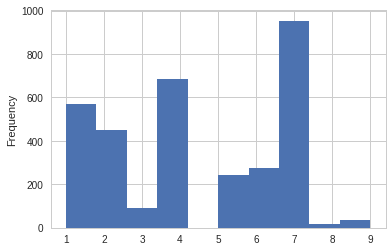

In [10]:
train['Class'].plot.hist();

### word counts in the text entries
just for now, a crude measure of how gene/variants relate to the text entries

In [11]:
train.loc[:, 'Word_count']  = train["Text"].apply(lambda x: len(x.split()))

FYI there's some repeated text entries'

In [12]:
len(train['Text']) - len(train['Text'].unique())

1400

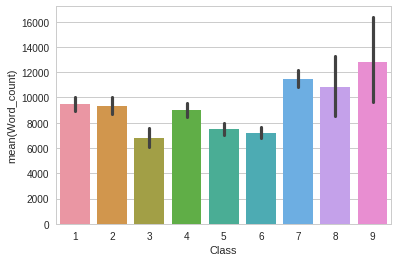

In [13]:
sns.barplot(data=train, x='Class', y='Word_count');

# Variants

## recode variations
Classifies variations into common types and standardizes their name. The order of commands in the fuc matters because deletions & insertions can happen simulteneously but coding is inconsistent. 
Testing: func is coding variations accurately. We might want to change the Fussion expression ("fs") because it could be problematic with new data, but hacky version works for now.

In [199]:
def var_recode(data, colname):
    recoded_colname = colname + '_recoded'
    #recode substitutions
    data[recoded_colname] = data[colname].str.replace('^[A-Z]\d+[A-Z\*]$|^(null)\d+[A-Z\*]$', 'Substitution')
    #recode deletions
    data.loc[data[colname].str.contains('del|silencing|hypermethylation', case=False), recoded_colname] = 'Deletion'
    #recode insertions
    data.loc[data[colname].str.contains('ins', case=False) , recoded_colname] = 'Insertion'
    #recode deletions/insertions
    data.loc[(data[colname].str.contains('del', case=False) & 
              data[colname].str.contains('ins', case=False)), recoded_colname] = 'InDel'
    #recode truncations
    data.loc[data[colname].str.contains('trunc', case=False), recoded_colname] = 'Truncation'
    #recode duplications
    data.loc[data[colname].str.contains('dup', case=False) , recoded_colname] = 'Duplication'
    #recode fusions 
    data.loc[data[colname].str.contains('fusion|fs', case=False), recoded_colname] = 'Fusion'

In [15]:
var_recode(train, 'Variation')

In [16]:
train.head()

,ID,Gene,Variation,Class,Text,Word_count,Variation_recoded
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089,Truncation
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756,Substitution
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756,Substitution
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572,Substitution
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202,Substitution


#### what are the most common variations?

In [17]:
train['Variation_recoded'].value_counts().nlargest(10)

Substitution      2644
Fusion             202
Deletion           175
Truncation          99
Amplification       71
Insertion           42
InDel               33
Duplication         13
Overexpression       6
X963_splice          1
Name: Variation_recoded, dtype: int64

### subset the data for exploratory data analysis
helpful for graphig and when analyzing gene x variants

In [18]:
variants = ['Substitution', 'Fusion', 'Deletion', 'Truncation', 'Amplification', 'Insertion', 'InDel', 'Duplication']

In [19]:
eda = train.loc[train['Variation_recoded'].isin(variants)]

### Most frequent variations per class

#### What is the most frequent variation?

In [20]:
train.groupby('Class')['Variation_recoded'].describe()

,count,unique,top,freq
Class,,,,
1,568,7,Substitution,402
2,452,10,Substitution,303
3,89,2,Substitution,88
4,686,14,Substitution,628
5,242,2,Substitution,239
6,275,5,Substitution,261
7,953,30,Substitution,674
8,19,3,Substitution,13
9,37,2,Substitution,36


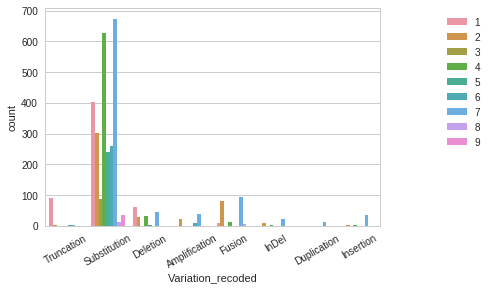

In [21]:
a = sns.countplot(data=eda, x='Variation_recoded', hue='Class')
a.legend(loc=9, bbox_to_anchor=(1.25, 1))
a.set_xticklabels(a.get_xticklabels(),rotation=30);

##### Aside from substitutions, what are other frequent variations per class?

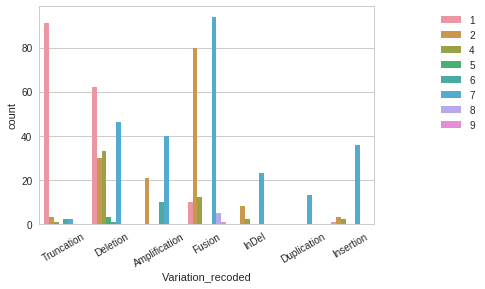

In [22]:
a = sns.countplot(data=eda[eda['Variation_recoded']!='Substitution'], x='Variation_recoded', hue='Class')
a.legend(loc=9, bbox_to_anchor=(1.25, 1))
a.set_xticklabels(a.get_xticklabels(),rotation=30);

# Recoding Substitutions

In [215]:
#aminoacid: 3code, 1code, charge
sub_dict= {'A': 'Neu', #'alanine'
           'R': 'Pos', #'arginine'
           'N': 'Neu', #'asparagine'
           'D': 'Neg', #'aspartic acid'
           'B': 'Neu', #'asparagine|aspartic acid'
           'C': 'Neu', #'cysteine'
           'E': 'Neg', #'glutamic acid'
           'Q': 'Neu', #'glutamine'
           'Z': 'Neu', #'glutamine|glutamic acid'
           'G': 'Neu', #'glycine'
           'H': 'Pos', #'histidine'
           'I': 'Neu', #'isoleucine'
           'L': 'Neu', #'leucine'
           'K': 'Pos', #'lysine'
           'M': 'Neu', #'methionine'
           'F': 'Neu', #'phenylalanine'
           'P': 'Neu', #'proline'
           'S': 'Neu', #'serine'
           'T': 'Neu', #'threonine'
           'W': 'Neu', #'tryptophan'
           'Y': 'Neu', #'tyrosine'
           'V': 'Neu' #'valine',
          }

In [258]:
def sub_recode(data, colname):
    recoded_colname = colname + '_recoded'
    data['s1'] = data.loc[data[colname].str.match('^[A-Z]\d+[A-Z]$')][colname].str[:1]
    data['s2'] = data.loc[data[colname].str.match('^[A-Z]\d+[A-Z]$')][colname].str[-1:]
    data['s1'].replace(sub_dict, inplace=True)
    data['s2'].replace(sub_dict, inplace=True)
    data['Sub_type'] = data['s1'] + data['s2']
    data.loc[data['Sub_type'].notnull(), recoded_colname] = data['Sub_type']
    data.drop(['s1', 's2', 'Sub_type'], axis=1, inplace=True)

In [259]:
sub_recode(train, 'Variation')

In [260]:
sub_recode(test, 'Variation')

In [262]:
test.head()

,ID,Gene,Variation,Text,Word_count,Variation_recoded,TP53,EGFR,BRCA1,BRCA2,PTEN,BCOR,SF3B1
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...,7417,PosNeu,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...,4710,NeuNeu,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...,11080,NeuNeu,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...,8380,NeuNeg,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...,11159,NeuNeu,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Genes

### calculate various measures of gene frequency per class

quick function to calculate gene frequency for a groupping variable
1) count of unique genes + Median word count to relate gene frequency with a crude text variable
2) total number of genes per group (similar to group frequency)
3) most frequent gene in each group
4) proportional frequency of gene accounting for size of group
5) reset index for easier plotting

In [210]:
def genefreq(data, group):
    newdf = data.groupby(group).agg({'Gene': pd.Series.nunique, 'Word_count': np.median})
    newdf['Gene_total'] = data.groupby(group)['Gene'].count()
    newdf['Gene_most_frequent'] = data.groupby(group)['Gene'].agg(lambda x: x.value_counts().idxmax())
    newdf['Gene_most_frequent_count'] = data.groupby(group)['Gene'].agg(lambda x: x.value_counts().max())
    newdf['Gene_p_unique'] = newdf['Gene']/newdf['Gene_total']
    newdf['Gene_p_most_frequent'] = newdf['Gene_most_frequent_count']/var_grp['Gene_total']
    newdf.reset_index(inplace=True)
    return newdf

In [211]:
class_grp = genefreq(train, 'Class')

### Which genes are the most frequent in each class?

In [212]:
class_grp

,Class,Gene,Word_count,Gene_total,Gene_most_frequent,Gene_most_frequent_count,Gene_p_unique,Gene_p_most_frequent
0,1,142,7305,568,TP53,83,0.250000,83.000000
1,2,96,6810,452,EGFR,45,0.212389,45.000000
2,3,26,5572,89,BRCA1,15,0.292135,15.000000
3,4,92,6351,686,PTEN,115,0.134111,115.000000
4,5,48,6463,242,BRCA1,90,0.198347,90.000000
5,6,56,6587,275,BRCA2,84,0.203636,1.183099
6,7,108,8254,953,EGFR,84,0.113326,84.000000
7,8,12,11253,19,BCOR,4,0.631579,4.000000
8,9,10,10930,37,SF3B1,15,0.270270,15.000000


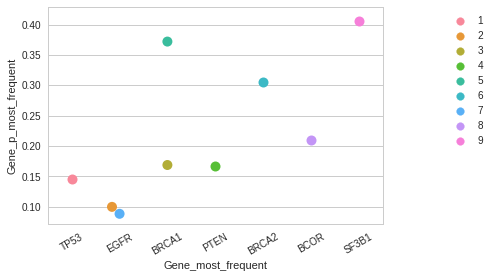

In [31]:
a = sns.swarmplot(y="Gene_p_most_frequent", x="Gene_most_frequent", hue='Class', data=class_grp, size=10)
a.legend(loc=9, bbox_to_anchor=(1.25, 1))
a.set_xticklabels(a.get_xticklabels(),rotation=30);

#### do the classes differ by the number (p) of unique genes associated with them?

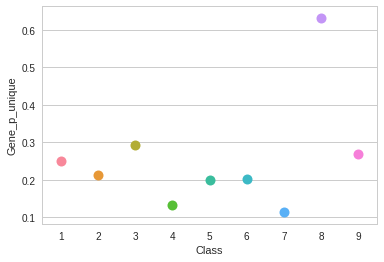

In [32]:
sns.swarmplot(y="Gene_p_unique", x="Class", data=class_grp, size=10)

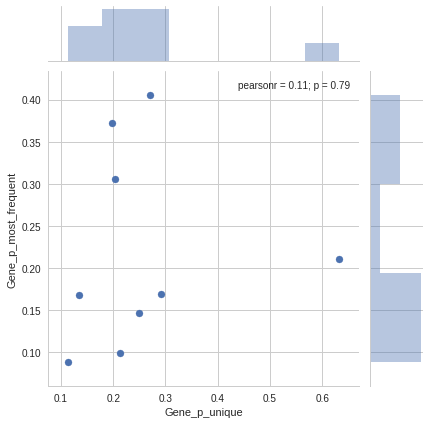

In [33]:
sns.jointplot("Gene_p_unique", "Gene_p_most_frequent",data=class_grp)

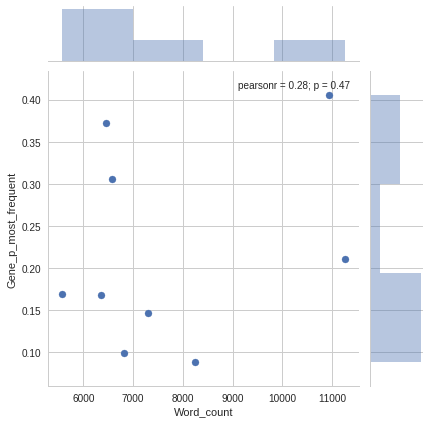

In [34]:
sns.jointplot("Word_count", "Gene_p_most_frequent",data=class_grp)

### Most frequent genes per class and variant type
looking only at the most common mutations by their generic terms

In [147]:
grp = genefreq(train, ['Class', 'Variation_recoded'])

In [149]:
grp.head()

,Class,Variation_recoded,Gene,Word_count,Gene_total,Gene_most_frequent,Gene_most_frequent_count,Gene_p_unique,Gene_p_most_frequent
0,1,596_619splice,1,184.0,1,HLA-A,1,1.000000,1.000000
1,1,Deletion,59,12149.0,62,PIK3R1,2,0.951613,0.011429
2,1,Fusion,8,4753.5,10,ERCC2,2,0.800000,0.009901
3,1,Insertion,1,5158.0,1,AR,1,1.000000,0.023810
4,1,Substitution,72,6239.5,402,TP53,82,0.179104,0.031014


#### Proportional frequency of the most common gene by class and variant

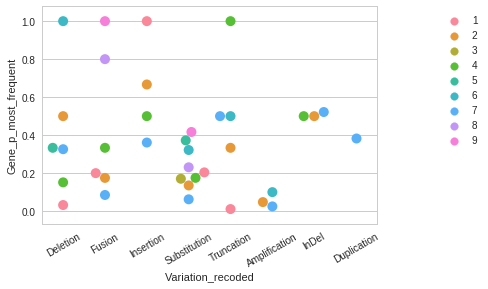

In [43]:
a = sns.swarmplot(x="Variation_recoded", y="Gene_p_most_frequent", hue='Class', data=grp, size=10)
a.legend(loc=9, bbox_to_anchor=(1.25, 1))
a.set_xticklabels(a.get_xticklabels(),rotation=30);

#### Proportional frequency of unique genes  by class and variant

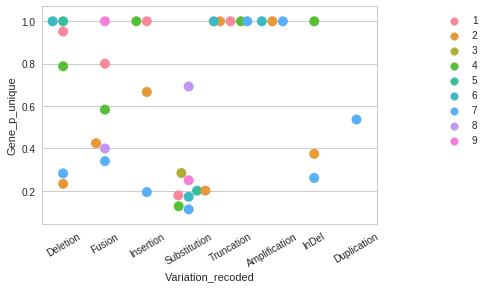

In [44]:
a = sns.swarmplot(x="Variation_recoded", y="Gene_p_unique", hue='Class', data=grp,size=10)
a.legend(loc=9, bbox_to_anchor=(1.25, 1))
a.set_xticklabels(a.get_xticklabels(),rotation=30);

#### does there seem to be any relation w/ word count?

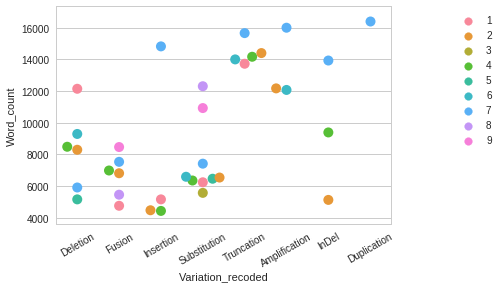

In [45]:
a = sns.swarmplot(x="Variation_recoded", y="Word_count", hue='Class', data=grp,size=10)
a.legend(loc=9, bbox_to_anchor=(1.25, 1))
a.set_xticklabels(a.get_xticklabels(),rotation=30);

#### birds-eye view of relationship between frequencies

In [ ]:
sns.pairplot(class_grp, hue='Class')

# discuss in group

### 1) is gene 'KIT' a real value?
looks like class 2 has many of those

In [46]:
grp.loc[grp['Class']==2]

,Class,Variation_recoded,Gene,Word_count,Gene_total,Gene_most_frequent,Gene_most_frequent_count,Gene_p_unique,Gene_p_most_frequent
5,2,Amplification,21,12174.0,21,CCND2,1,1.000000,0.047619
6,2,Deletion,7,8294.0,30,KIT,15,0.233333,0.500000
7,2,Fusion,34,6810.0,80,PDGFRB,14,0.425000,0.175000
8,2,InDel,3,5124.5,8,KIT,4,0.375000,0.500000
9,2,Insertion,2,4470.0,3,KIT,2,0.666667,0.666667
10,2,Substitution,61,6538.0,303,EGFR,41,0.201320,0.135314
11,2,Truncation,3,14406.0,3,CCND1,1,1.000000,0.333333


### 2) which features to include?
based on eda, it looks like classes vary most by their most frequent genes and their proportional frequency.
variation type might be additionally helpful to distinguish between couple of classes, but it would be sufficient to have the recoded variation column in addition to the common genes as dummy variables (e.g., entries get a 1 or 0 if they contain the specific gene).

Convert most frequent genes into dummy variables:
    - TP53
    - EGFR
    - BRCA1
    - BRCA2
    - PTEN
    - BCOR
    - SF3B1

### Create dummy variables w the most common genes

In [48]:
top_genes = ['TP53', 'EGFR', 'BRCA1', 'BRCA2', 'PTEN', 'BCOR', 'SF3B1']

In [49]:
def gene_dummy(data, top_genes):
    for gene in top_genes:
        data.loc[data['Gene'].notnull(), gene] = 0
        data.loc[data['Gene']==gene, gene] = 1

In [50]:
gene_dummy(train, top_genes)

it worked! I checked all new variables

In [64]:
train.loc[train['SF3B1']==1].head()

,ID,Gene,Variation,Class,Text,Word_count,Variation_recoded,TP53,EGFR,BRCA1,BRCA2,PTEN,BCOR,SF3B1
121,121,SF3B1,K700R,8,The RNA maturation is an important and complex...,20626,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,1.0
122,122,SF3B1,R625C,9,The RNA maturation is an important and complex...,11497,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,1.0
123,123,SF3B1,E622D,9,The splicing factor SF3B1 is the most commonly...,10930,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,1.0
124,124,SF3B1,H662Q,9,The splicing factor SF3B1 is the most commonly...,10930,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,1.0
125,125,SF3B1,R625D,9,The RNA maturation is an important and complex...,1147,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# preproces the test dataset

read and files

In [73]:
test_v = pd.read_csv('/home/bunge/bguerra/Desktop/git/cdips/test_variants/test_variants')

In [74]:
test_t = pd.read_csv('/home/bunge/bguerra/Desktop/git/cdips/test_text/test_text', sep='\|\|',skiprows=1, engine='python', names=["ID","Text"])

In [75]:
test = test_v.merge(test_t, how="inner", left_on="ID", right_on="ID")

Preprocess: word count and  recode variations

In [76]:
test.loc[:, 'Word_count']  = test["Text"].apply(lambda x: len(x.split()))

In [200]:
var_recode(test, 'Variation')

In [254]:
sub_recode(test, 'Variation')

In [78]:
gene_dummy(test, top_genes)

In [257]:
train.head()

,ID,Gene,Variation,Class,Text,Word_count,Variation_recoded,TP53,EGFR,BRCA1,BRCA2,PTEN,BCOR,SF3B1,Sub_type
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089,Truncation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NeuNeg
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NeuNeg
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202,Substitution,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NeuNeu


merge with group's

In [263]:
test.to_csv('/home/bunge/bguerra/Desktop/git/cdips/test_bg.csv')

In [264]:
train.to_csv('/home/bunge/bguerra/Desktop/git/cdips/train_bg.csv')

# EDA with test data

In [202]:
test['Variation_recoded'].value_counts().nlargest(10)

Substitution                      5581
Deletion                            24
Truncation                          19
Fusion                              17
Amplification                        8
Insertion                            8
InDel                                6
Duplication                          3
Single Nucleotide Polymorphism       1
X1006_splice                         1
Name: Variation_recoded, dtype: int64

Substitutions are 99% of the variants in the test dataset vs. 80% in the train data

In [203]:
5581/5668

0.9846506704304869

In [89]:
2644/3321

0.7961457392351702

In [150]:
test_grp = genefreq(test, 'Variation_recoded')

In [157]:
test_grp.loc[test_grp['Variation_recoded'].isin(variants)]

,Variation_recoded,Gene,Word_count,Gene_total,Gene_most_frequent,Gene_most_frequent_count,Gene_p_unique,Gene_p_most_frequent
0,Amplification,8,9778.0,8,AURKB,1,1.000000,0.014085
1,Deletion,21,12969.0,24,KIT,4,0.875000,0.022857
2,Duplication,3,4910.0,3,EGFR,1,1.000000,0.076923
3,Fusion,14,6110.0,17,PDGFRA,3,0.823529,0.014851
4,InDel,4,7323.5,6,BRAF,2,0.666667,0.060606
5,Insertion,4,14829.0,8,EGFR,3,0.500000,0.071429
7,Substitution,1365,8338.0,5562,F8,134,0.245415,0.050681
8,Truncation,19,13385.0,19,TET2,1,1.000000,0.010101


In [153]:
var_grp = genefreq(train, 'Variation_recoded')

In [156]:
var_grp.loc[var_grp['Variation_recoded'].isin(variants)]

,Variation_recoded,Gene,Word_count,Gene_total,Gene_most_frequent,Gene_most_frequent_count,Gene_p_unique,Gene_p_most_frequent
6,Amplification,71,13847.0,71,CDK8,1,1.000000,0.014085
12,Deletion,99,9650.0,175,KIT,30,0.565714,0.171429
13,Duplication,7,16427.0,13,EGFR,5,0.538462,0.384615
23,Fusion,56,6647.5,202,PDGFRB,18,0.277228,0.089109
24,InDel,9,8294.0,33,EGFR,13,0.272727,0.393939
25,Insertion,11,11094.0,42,FLT3,13,0.261905,0.309524
32,Substitution,183,6542.0,2644,BRCA1,258,0.069213,0.097579
35,Truncation,96,13794.0,99,NOTCH2,2,0.969697,0.020202
